In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from matplotlib import pyplot as plt 
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

from utils import * 

In [2]:
def date_to_datetime(data):
    data.time = pd.to_datetime(data.time, infer_datetime_format=True)

    data = data.set_index('time', drop=True)  

    return data    

In [3]:
def slice_dates(data, beginning_date, end_date):
    return data[(data.index>=beginning_date)&(data.index<=end_date)]


In [4]:
data_v1 = pd.read_csv("data/data_v1.csv")
data_v2 = pd.read_csv("data/data_v2.csv")

data_v1 = date_to_datetime(data_v1)
data_v2 = date_to_datetime(data_v2)


In [5]:
data = data_v2.dropna()

In [214]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':[0, 1, 2, 24],
              'num_periods_diffed':[0],
              'hour': [True],
              'weekday':[True],
              'month':[True],
              'holidays': [True],
              'rolling' : [[]]#[[],[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [215]:
beginning_date = '2017-11-11'#'2015-01-01'
val_split_date = '2017-12-11'
test_split_date = '2017-12-18'
train = data.loc[(beginning_date <= data.index) & (data.index < val_split_date)]
val = data.loc[(val_split_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [216]:
%%time 
# This is another cell that will take a long time to run. 

def wrap_model_selection(params): 
    predictions = predict_n_periods(series_=train, 
                      n_periods=len(val), 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                    hour=params['hour'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=params["rolling"]
                    )
    return [params,mean_absolute_error(val.price,predictions)]

res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

<timed exec>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 263 ms, sys: 236 ms, total: 499 ms
Wall time: 4min 37s


In [217]:
df = pd.DataFrame(res, columns=['params','error'])
df.sort_values('error')

,params,error
6,"{'holidays': True, 'hour': True, 'model': ([De...",7.616145
7,"{'holidays': True, 'hour': True, 'model': ([De...",7.723373
2,"{'holidays': True, 'hour': True, 'model': Line...",8.508677
3,"{'holidays': True, 'hour': True, 'model': Line...",8.569918
1,"{'holidays': True, 'hour': True, 'model': Line...",9.007045
5,"{'holidays': True, 'hour': True, 'model': ([De...",9.690648
4,"{'holidays': True, 'hour': True, 'model': ([De...",10.888012
0,"{'holidays': True, 'hour': True, 'model': Line...",12.049514


In [220]:
df.sort_values('error').iloc[0][0]

{'holidays': True,
 'hour': True,
 'model': GradientBoostingRegressor(),
 'month': True,
 'num_periods_diffed': 0,
 'num_periods_lagged': 12,
 'rolling': [],
 'weekday': True}

  0%|          | 0/168 [00:00<?, ?it/s]


In [19]:
"""
test_split_date = '2016-12-18'
train_start_date = '2016-11-18'
test_end_date = '2016-12-25'

train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]#.drop(["exog"], axis=1)
test = data.loc[(data.index >= test_split_date) & (data.index < test_end_date)]
"""

'\ntest_split_date = \'2016-12-18\'\ntrain_start_date = \'2016-11-18\'\ntest_end_date = \'2016-12-25\'\n\ntrain = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]#.drop(["exog"], axis=1)\ntest = data.loc[(data.index >= test_split_date) & (data.index < test_end_date)]\n'

In [221]:
#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2017-11-18'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

In [226]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

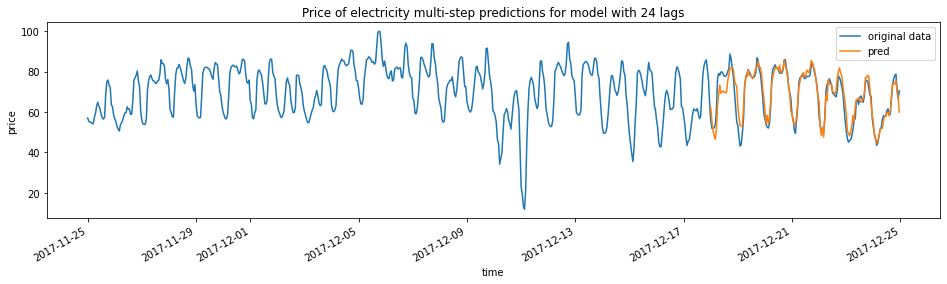

In [227]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();

In [228]:
mean_absolute_error(test.price,predictions)

3.208449621326043

In [206]:
## PREDICTING TEST SET - submission 3 
test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(), 
                  num_periods_lagged=0,
                  num_periods_diffed=1,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

KeyboardInterrupt: 

<AxesSubplot:>

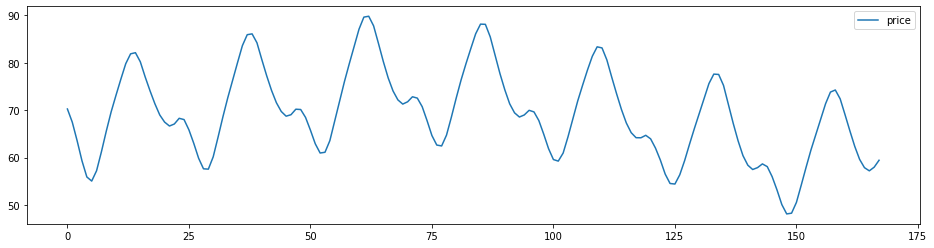

In [185]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [97]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("linear_regression_submission3", index=False)

In [229]:
## PREDICTING TEST SET - submission 4 
test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

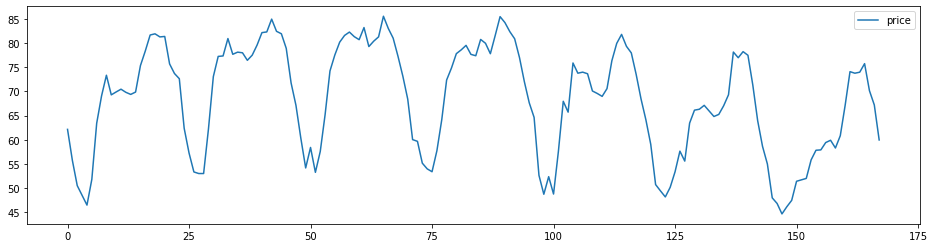

In [230]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [233]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_boost_submission4", index=False)

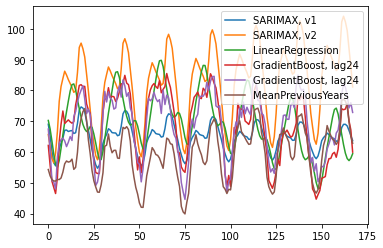

In [9]:
plt.plot(pd.read_csv("sarimax_no_exogenus_v1"), label="SARIMAX, v1") ##15
plt.plot(pd.read_csv("sarimax_no_exogenus_v2"), label="SARIMAX, v2") ##33
plt.plot(pd.read_csv("linear_regression_submission3"), label="LinearRegression") ##20 
plt.plot(pd.read_csv("gradient_boost_submission4"), label="GradientBoost, lag24") ##19
plt.plot(pd.read_csv("gradient_boost_with_exog_lag24"), label="GradientBoost, lag24") ##19

plt.plot(pd.read_csv("mean_previous_years"), label="MeanPreviousYears") ##11.85

plt.legend()

In [5]:
##ADDING EXOGENUS DATA
data = data_v2.copy()
data = build_exog_features(data, 168)

In [6]:
data = data.dropna()

In [7]:
#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2017-11-18'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [248]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

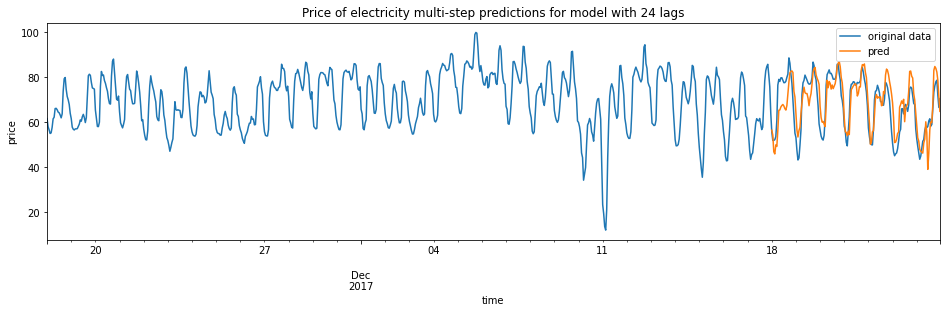

In [249]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();

In [250]:
mean_absolute_error(test.price,predictions)

6.001709177527141

In [251]:
## PREDICTING TEST SET  - with exogenous data
test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

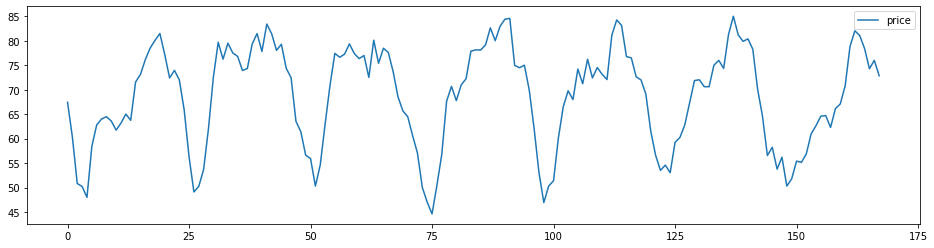

In [252]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [255]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_boost_with_exog_lag24", index=False)

In [8]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                
                  num_periods_lagged=0,
                                lags = [24],
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

6.219538971003211

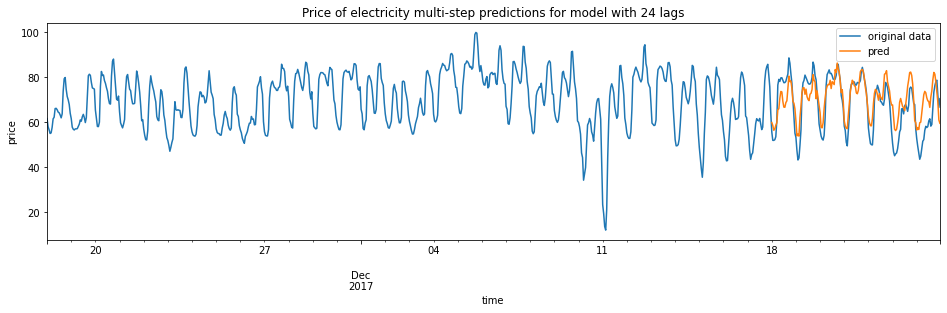

In [11]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();
mean_absolute_error(test.price,predictions)

In [18]:

#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2016-12-18'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                
                  num_periods_lagged=0,
                                lags = [1, 2, 12, 24],
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

KeyboardInterrupt: 

8.035567741940786

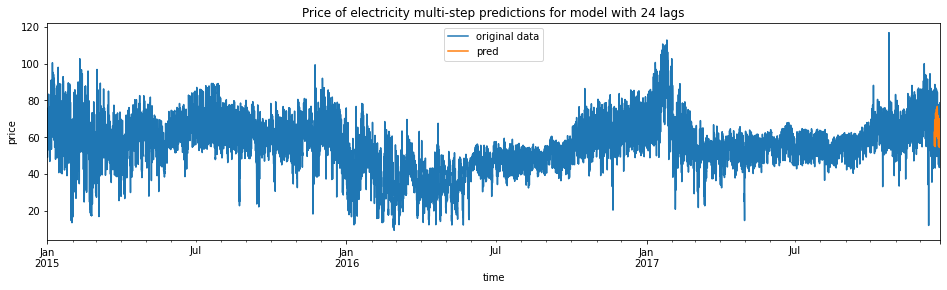

In [15]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();
mean_absolute_error(test.price,predictions)